# Cohort selection

## Problem

We are launching a recommendation tool that identifies vendor cohorts and
suggests performance improvements based on peer comparisons within those
cohorts.  This ad hoc approach creates two risks for our MVP rollout: Weak
statistical foundation: We haven't validated whether our cohorts actually group
similar-performing vendors together Stakeholder confidence: Without a principled
justification for cohort boundaries, leadership are questioning recommendation
validity For more details, see [RFC - Reco cohort updating](https://docs.google.com/document/d/1N57UfysXpHLFVXMAi5htYw2L8hBySiKq9frPIBlvaPk/edit?tab=t.0#heading=h.wcy3kyozl6o0)

## Current cohort rule

Our current cohort rule uses a six-level nested hierarchy (Country → City → Area
→ Price → Cuisine → Grade) that was designed primarily for explainability to
account managers rather than analytical rigor. One shortcoming of the cohort
rule is that when there are an insufficient number of chains in a cohort, the
fallback is often to a broad “All” category. For example, 8% of vendors in the
UAE are in a category with the following dimension values

- Entity: tb_ae 
- City: All 
- Area: All 
- Priciness: All 
- Cuisine: All 
- Vendor Grade: All

Why so many? Our belief is that this is due to the fallback logic. A fallback
occurs when a proposed cohort has too few vendors for reliable comparison. In
the current rule, we switch from a granular cohort to the broadest relevant
cohort with the most chain ids.

## This iteration


## Recommendations 



In [1]:
from pathlib import Path
from cohorts.cohort_statistics import (
    process_dataframes_for_outliers, 
    process_dataframes,
    load_dataframes_by_type
    )
from cohorts.config_manager import TableConfig
from typing import Dict, List, Optional, Tuple
from matplotlib.colors import LinearSegmentedColormap

import os
import warnings
import numpy as np
import pandas as pd
import pandas_gbq
import seaborn as sns
import bigframes.pandas as bpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


%load_ext google.cloud.bigquery
BQ_PROJECT_ID = "dhh-ncr-stg"

# where to save plots
CURRENT_DIR = Path(os.getcwd())
BASE_PLOT_PATH = CURRENT_DIR.parent / "figures" 

TALABAT_ORANGE = '#FF5733'
DH_RED = '#C9332D'  
DH_NAVY = '#3A3FFF'

path_config = TableConfig()

/Users/patrick.doupe/DH/ad_hoc/cohorts/.venv/lib/python3.13/site-packages/google/cloud/bigquery/__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(


## Looking at cohorts

In [2]:
BASE_SQL_QUERY = """
SELECT DISTINCT
  t.cohort_id,
  JSON_VALUE(t.cohort_features, '$.entity') AS entity,
  JSON_VALUE(t.cohort_features, '$.city') AS city,
  JSON_VALUE(t.cohort_features, '$.area') AS area,
  JSON_VALUE(t.cohort_features, '$.budget') AS bugdet,
  JSON_VALUE(t.cohort_features, '$.cuisine') AS cuisine,
  JSON_VALUE(t.cohort_features, '$.vendor_grade') AS vendor_grade,
  JSON_VALUE(t.cohort_features, '$.key_account_sub_category') AS key_account_sub_cat,
  COUNT(t.vendor_code) AS num_vendors
FROM {table_path} AS t
GROUP BY ALL
"""

In [3]:
print("\n===== LOADING 'cohort data' =====")
cohort_data_dfs = load_dataframes_by_type(
    specific_data_type="cohort data",
    base_sql_query_template=BASE_SQL_QUERY,
    config=path_config,
    project_id=BQ_PROJECT_ID
)


===== LOADING 'cohort data' =====
Starting to load 'cohort data' DataFrames...
------------------------------------------------------------
Reading: Key='base-even-cohort data-original'
  Table Path: logistics-vendor-production.pa_staging.devin_original_cohort_step3
Downloading: 100%|██████████|
  Successfully loaded 8872 rows.
------------------------------------------------------------
Reading: Key='base-even-cohort data-current'
  Table Path: logistics-vendor-production.pa_staging.devin_smart_reco_vendor_cohorts_step_3
Downloading: 100%|██████████|
  Successfully loaded 5008 rows.
------------------------------------------------------------
Reading: Key='base-uneven-cohort data-current'
  Table Path: logistics-vendor-production.pa_staging.devin_smart_reco_vendor_cohorts_step_3_uneven
Downloading: 100%|██████████|
  Successfully loaded 9081 rows.
------------------------------------------------------------
Reading: Key='key account segment addition-even-cohort data-current'
  Table 

In [4]:
try:
    current_even_cohort = "base-even-cohort data-current"
    df_bm = cohort_data_dfs[current_even_cohort]
    print(f"\nAccessed DataFrame using key '{current_even_cohort}':")
except KeyError:
    print(f"\nDataFrame with key '{current_even_cohort}' not found (might not have been loaded due to an error).")


Accessed DataFrame using key 'base-even-cohort data-current':


In [5]:
try:
    original_even_cohort = "base-even-cohort data-original"
    df_original = cohort_data_dfs[original_even_cohort]
    print(f"\nAccessed DataFrame using key '{original_even_cohort}':")
except KeyError:
    print(f"\nDataFrame with key '{original_even_cohort}' not found (might not have been loaded due to an error).")


Accessed DataFrame using key 'base-even-cohort data-original':


In [6]:
df_bm.sort_values(by='num_vendors', ascending=False).head(20)

,cohort_id,entity,city,area,bugdet,cuisine,vendor_grade,key_account_sub_cat,num_vendors
473,84548,hf_eg,cairo,All,All,All,NA,None,439
232,84667,hf_eg,cairo,All,All,Desserts,D,None,364
639,83303,tb_bh,bahrain,All,All,All,NA,None,329
212,106354,tb_ae,dubai,Business Bay,All,All,NA,None,302
383,84600,hf_eg,cairo,All,All,Burgers,D,None,282
265,84858,hf_eg,cairo,All,All,Pizza,D,None,268
18,85918,tb_ae,dubai,All,All,All,NA,None,262
557,73235,gv_ro,Bucharest,All,All,PIZZA,D,None,246
581,79830,tb_ae,abu dhabi,All,All,All,NA,None,230
166,84732,hf_eg,cairo,All,All,Grills,D,None,229


### Result 1: we have fewer extreme sized cohorts

In [7]:
cohort_size = {}
for key, value in cohort_data_dfs.items():
    tmp_num_cohorts = value.cohort_id.nunique()
    cohort_size[key] = tmp_num_cohorts

(
    pd.DataFrame.from_dict(cohort_size, orient='index', columns=['num_unique_cohorts'])
    .reset_index()
    .sort_values(by='num_unique_cohorts', ascending=False)
)


,index,num_unique_cohorts
6,no chain logic-uneven-cohort data-current,12110
4,key account segment addition-uneven-cohort dat...,10167
2,base-uneven-cohort data-current,9081
0,base-even-cohort data-original,8872
7,key account no chain-even-cohort data-current,6895
5,no chain logic-even-cohort data-current,6785
3,key account segment addition-even-cohort data-...,5496
1,base-even-cohort data-current,5008


The top four rules by number of cohorts are the uneven weighting rules. Original cohorting rule splits these. 

How many 'big' cohorts do we get?

In [8]:
thresholds = [10, 100, 1000, 10000]
all_cohort_outlier_metrics = [] 

for cohort_rule, df in cohort_data_dfs.items():
    # Pre-calculate num_cohorts once per DataFrame
    num_cohorts = df['cohort_id'].nunique()

    # Handle cases where cohort_id might be empty or all NaNs
    if num_cohorts == 0:
        print(f"Warning: No unique cohorts found for '{cohort_rule}'. Outlier percentages will be 0.")

    for threshold in thresholds:
        # Calculate num_outliers for the current threshold
        num_outliers = df.loc[df['num_vendors'] > threshold].shape[0]

        # Calculate percentage, handling potential division by zero
        pct_outliers = round(100 * num_outliers / num_cohorts, 2) if num_cohorts > 0 else 0

        # Append a dictionary for the current row's data
        all_cohort_outlier_metrics.append({
            'cohort_rule': cohort_rule,
            'threshold': threshold,
            'num_cohorts': num_cohorts,
            'num_outliers': num_outliers,
            'pct_outliers': pct_outliers
        })

df_lge_cohorts = pd.DataFrame(all_cohort_outlier_metrics)

In [9]:
df_lge_cohorts

,cohort_rule,threshold,num_cohorts,num_outliers,pct_outliers
0,base-even-cohort data-original,10,8872,2067,23.30
1,base-even-cohort data-original,100,8872,19,0.21
2,base-even-cohort data-original,1000,8872,3,0.03
3,base-even-cohort data-original,10000,8872,0,0.00
4,base-even-cohort data-current,10,5008,2326,46.45
5,base-even-cohort data-current,100,5008,85,1.70
6,base-even-cohort data-current,1000,5008,0,0.00
7,base-even-cohort data-current,10000,5008,0,0.00
8,base-uneven-cohort data-current,10,9081,2606,28.70
9,base-uneven-cohort data-current,100,9081,15,0.17


- Most other cohorting rules work better than original (no cohorts with more than 1000 vendors)
- Excent no chain logic uneven, they even have a cohort with greater than 10k

In [10]:
def plot_num_vendors_boxplots(
    dataframes: Dict[str, pd.DataFrame],
    plot_title: str,
    y_label: str = 'Number of Vendors',
    figure_size: Optional[Tuple[float, float]] = None,
    x_label_rotation: int = 45,
    winsorize_upper_bound: Optional[float] = None,
    save_path: Optional[str] = None, # New: Path to save the figure (e.g., 'plots/my_boxplot.png')
    show_plot: bool = True # New: Control whether to display the plot immediately
) -> None:
    """
    Generates box plots for the 'num_vendors' column across multiple Dataframes.

    Args:
        dataframes (Dict[str, pd.DataFrame]): A dictionary where keys are plot labels
                                              and values are pandas DataFrames, each
                                              expected to have a 'num_vendors' column.
        plot_title (str): The title for the generated box plot.
        y_label (str): The label for the y-axis. Defaults to 'Number of Vendors'.
        figure_size (Optional[Tuple[float, float]]): The size of the figure (width, height) in inches.
                                                   If None, it defaults based on the number of plots.
        x_label_rotation (int): Rotation angle for x-axis labels in degrees.
                                Defaults to 45.
        winsorize_upper_bound (Optional[float]): If provided, 'num_vendors' values
                                                 greater than this bound will be capped
                                                 at this bound for plotting.
                                                 (This is a form of capping/winsorization).
        save_path (Optional[str]): If provided, the plot will be saved to this file path.
                                   Includes directory creation.
        show_plot (bool): If True, calls plt.show() to display the plot immediately.
                          Defaults to True. If saving, you might set this to False.
    """
    data_to_plot: List[pd.Series] = []
    labels: List[str] = []
    skipped_dfs_info: List[str] = []

    for key, df in dataframes.items():
        if 'num_vendors' in df.columns:
            if pd.api.types.is_numeric_dtype(df['num_vendors']) and not df['num_vendors'].empty:
                series_to_plot = df['num_vendors'].copy() # Work on a copy to avoid modifying original DF

                if winsorize_upper_bound is not None:
                    series_to_plot = series_to_plot.clip(upper=winsorize_upper_bound)

                data_to_plot.append(series_to_plot)
                labels.append(key)
            else:
                skipped_dfs_info.append(f"'{key}' (num_vendors not numeric or empty)")
        else:
            skipped_dfs_info.append(f"'{key}' (missing num_vendors column)")

    if skipped_dfs_info:
        print(f"Warning for '{plot_title}': Skipped plotting for:\n- " + "\n- ".join(skipped_dfs_info))

    if not data_to_plot:
        print(f"No valid 'num_vendors' data found for '{plot_title}' to create boxplot.")
        return # Exit if no data to plot

    # Determine figure size if not explicitly provided
    if figure_size is None:
        dynamic_width = max(8, len(labels) * 1.0) # Adjust factor for potentially more compact plots
        figure_size = (dynamic_width, 6)

    fig, ax = plt.subplots(figsize=figure_size) # Use fig, ax for more control

    boxplot_properties = dict(
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', edgecolor='blue'),
        medianprops=dict(color='red'),
        whiskerprops=dict(color='blue'),
        capprops=dict(color='blue')
    )

    ax.boxplot(data_to_plot, tick_labels=labels, **boxplot_properties)

    ax.set_title(plot_title)
    ax.set_ylabel(y_label)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xticks(rotation=x_label_rotation, ha='right')
    plt.tight_layout()

    # --- New Save and Show Logic ---
    if save_path:
        # Ensure the directory exists
        output_dir = os.path.dirname(save_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"Created directory: {output_dir}")

        plt.savefig(save_path, bbox_inches='tight') # bbox_inches='tight' often helps with clipped labels
        print(f"Plot saved to: {save_path}")

    if show_plot:
        plt.show()
    else:
        # If not showing immediately, explicitly close the figure to free memory
        plt.close(fig)

Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/original_num_vendors_boxplot.png


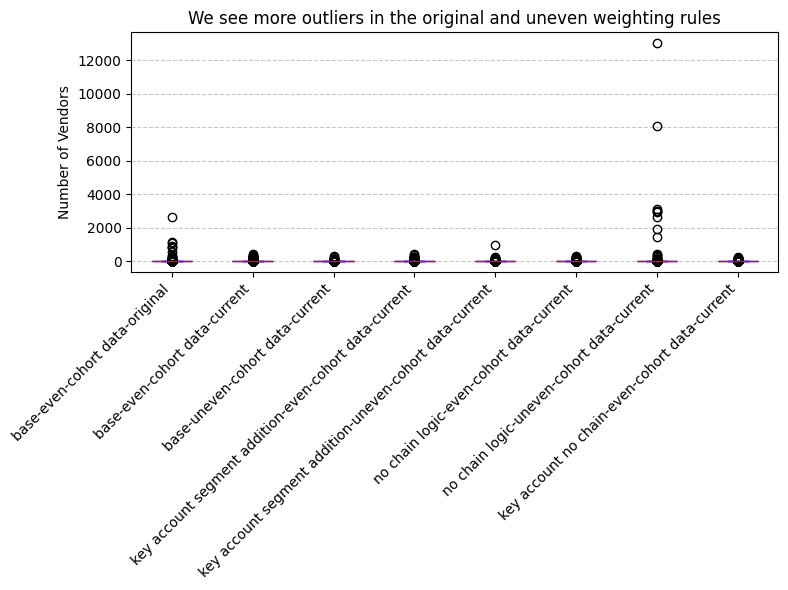

In [11]:
plot_num_vendors_boxplots(
    dataframes=cohort_data_dfs,
    plot_title='We see more outliers in the original and uneven weighting rules',
    y_label='Number of Vendors',
    save_path=BASE_PLOT_PATH / 'original_num_vendors_boxplot.png', # Save the figure
    show_plot=True # Also display it
)


Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/winsorized_num_vendors_boxplot.png


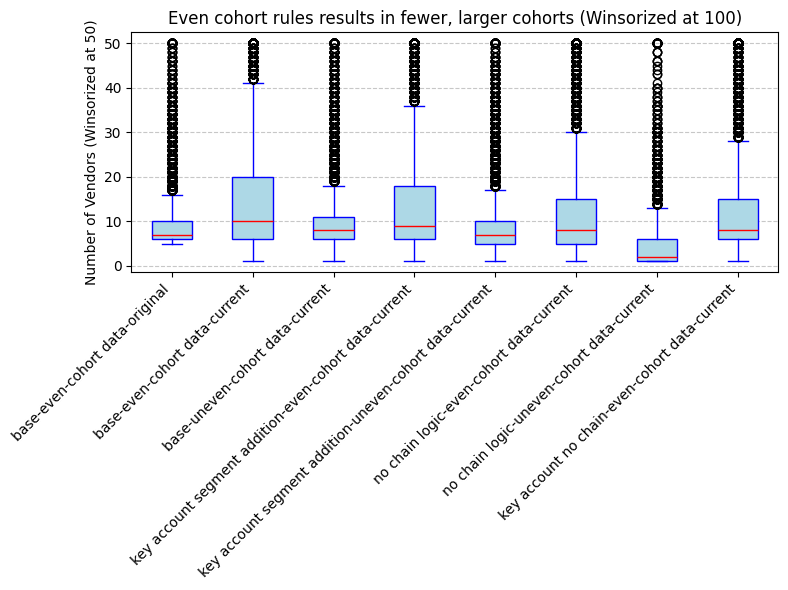

In [12]:
plot_num_vendors_boxplots(
    dataframes=cohort_data_dfs,
    plot_title='Even cohort rules results in fewer, larger cohorts (Winsorized at 100)',
    y_label='Number of Vendors (Winsorized at 50)',
    winsorize_upper_bound=50, 
    save_path=BASE_PLOT_PATH / 'winsorized_num_vendors_boxplot.png', # Save the figure
    show_plot=True # Also display it
)


In [13]:
cohort_data_dfs['base-even-cohort data-original'].sort_values(by='num_vendors', ascending=False)

,cohort_id,entity,city,area,bugdet,cuisine,vendor_grade,key_account_sub_cat,num_vendors
2067,132679,tb_ae,All,All,All,All,All,None,2644
2064,132719,tb_om,All,All,All,All,All,None,1174
2066,132671,hf_eg,All,All,All,All,All,None,1081
2065,132695,tb_iq,All,All,All,All,All,None,918
2061,132711,tb_kw,All,All,All,All,All,None,876
...,...,...,...,...,...,...,...,...,...
2352,84811,tb_ae,abu dhabi,Al Nahyan,All,Japanese,D,None,5
2353,84831,tb_ae,abu dhabi,Al Nahyan,All,Manaqeesh,All,None,5
2354,84866,tb_ae,abu dhabi,Al Nahyan,All,Poke,D,None,5
2356,85560,tb_ae,abu dhabi,Al Najda,All,All,C,None,5


In [14]:
cohort_data_dfs['base-even-cohort data-current'].sort_values(by='num_vendors', ascending=False)

,cohort_id,entity,city,area,bugdet,cuisine,vendor_grade,key_account_sub_cat,num_vendors
473,84548,hf_eg,cairo,All,All,All,NA,None,439
232,84667,hf_eg,cairo,All,All,Desserts,D,None,364
639,83303,tb_bh,bahrain,All,All,All,NA,None,329
212,106354,tb_ae,dubai,Business Bay,All,All,NA,None,302
383,84600,hf_eg,cairo,All,All,Burgers,D,None,282
...,...,...,...,...,...,...,...,...,...
3940,189431,tb_kw,hawally,Salwa,All,All,All,None,1
2451,68873,tb_om,All,All,All,Grills,All,None,1
4622,42973,tb_ae,ras al khaima,Al Nakheel Area,All,Arabic,All,None,1
4973,203863,tb_iq,duhok,Tenahi,All,All,All,None,1


In [15]:
cohort_data_dfs['key account segment addition-even-cohort data-current']

,cohort_id,entity,city,area,bugdet,cuisine,vendor_grade,key_account_sub_cat,num_vendors
0,142020,tb_ae,dubai,All,All,Poke,D,National KA,13
1,159867,tb_kw,farwaniya,Ardhiya,All,All,NA,All,111
2,104500,tb_om,All,All,All,All,C,Local Hero,27
3,114305,tb_ae,All,All,All,Specialty Store,D,Local Hero,61
4,167539,tb_ae,abu dhabi,Bani Yas East,All,All,D,All,26
...,...,...,...,...,...,...,...,...,...
5491,139408,tb_qa,doha,All,All,All,All,Local Hero,1
5492,109484,tb_om,All,All,All,Grills,B,All,1
5493,114100,tb_kw,All,All,All,Shawarma,D,National KA,1
5494,233327,tb_kw,al jahra,Jahra - Jahra Area,All,All,All,Local Hero,1


In [16]:
cohort_data_dfs['key account segment addition-even-cohort data-current'].sort_values(by='num_vendors', ascending=False)

,cohort_id,entity,city,area,bugdet,cuisine,vendor_grade,key_account_sub_cat,num_vendors
13,138130,hf_eg,cairo,All,All,All,NA,All,436
10,138346,hf_eg,cairo,All,All,Desserts,D,All,356
264,138224,hf_eg,cairo,All,All,Burgers,D,All,282
258,138660,hf_eg,cairo,All,All,Pizza,D,All,268
276,140700,tb_ae,dubai,All,All,All,NA,Local Hero,249
...,...,...,...,...,...,...,...,...,...
4215,175176,tb_ae,dubai,Business Bay,All,All,All,All,1
5342,149126,hf_eg,port said,All,All,All,D,All,1
4646,104816,tb_ae,All,All,All,Arabic,All,Local Hero,1
5417,109676,tb_kw,All,All,All,Healthy,All,Local Hero,1


In [17]:
cohort_data_dfs['no chain logic-even-cohort data-current'].sort_values(by='num_vendors', ascending=True)

,cohort_id,entity,city,area,bugdet,cuisine,vendor_grade,key_account_sub_cat,num_vendors
6784,168765,hf_eg,mansoura,Mostashfayat El Gama'a,All,Coffee & Tea,All,None,1
6084,190026,tb_bh,bahrain,Sanad,All,Turkish,All,None,1
6085,116823,tb_qa,dubai,Dubai Silicon Oasis,All,All,NA,None,1
6461,196867,hf_eg,alexandria,Sidi Gaber,All,Grills,All,None,1
6460,63941,tb_kw,mubarak al-kabir,Al-Qurain,All,Desserts,All,None,1
...,...,...,...,...,...,...,...,...,...
693,84732,hf_eg,cairo,All,All,Grills,D,None,215
825,73235,gv_ro,Bucharest,All,All,PIZZA,D,None,246
600,84858,hf_eg,cairo,All,All,Pizza,D,None,257
264,84600,hf_eg,cairo,All,All,Burgers,D,None,261


In [18]:
cohort_data_dfs['no chain logic-even-cohort data-current'].sample(n=20)

,cohort_id,entity,city,area,bugdet,cuisine,vendor_grade,key_account_sub_cat,num_vendors
6775,126049,hf_eg,mansoura,Ezbet El Shal,All,All,C,None,1
165,85942,tb_ae,dubai,All,All,Arabic,NA,None,127
2621,211821,tb_kw,hawally,Zahra,All,All,C,None,21
2391,82220,hf_eg,alexandria,All,All,Pasta,NA,None,12
2275,169062,tb_qa,doha,Muaither,All,All,NA,None,26
2994,85853,tb_qa,doha,All,All,Turkish,A,None,9
4911,92348,tb_om,sohar,All,All,Beverages,D,None,9
2581,101723,tb_ae,abu dhabi,Bani Yas East,All,Desserts,D,None,12
5822,75063,gv_ro,Iasi,All,All,PIZZA,C,None,11
3400,97221,tb_kw,farwaniya,Ardiya Small Industrial,All,Desserts,C,None,5


In [56]:
cohort_data_dfs['key account no chain-even-cohort data-current']

,cohort_id,entity,city,area,bugdet,cuisine,vendor_grade,key_account_sub_cat,num_vendors
0,150236,tb_jo,salt,All,All,All,D,All,14
1,258920,tb_iq,duhok,Malta Street,All,All,All,Local Hero,6
2,126950,gv_ro,Timisoara,All,All,PIZZA,D,All,27
3,144604,hf_eg,hurghada,All,All,All,D,All,33
4,119332,gv_ro,Craiova,All,All,TURKISH,B,Local Hero,5
...,...,...,...,...,...,...,...,...,...
6890,86682,tb_jo,zarqa,Al Souq,All,All,D,All,9
6891,153838,tb_jo,zarqa,All,All,All,All,National KA,6
6892,219960,tb_jo,zarqa,Hay Al Iskan,All,Pizza,All,National KA,1
6893,154071,tb_jo,zarqa,All,All,Shawarma,All,All,6


In [20]:
for key, val in cohort_data_dfs.items():
    print(key, val.loc[val.num_vendors < 5].shape[0] / val.shape[0])

base-even-cohort data-original 0.0
base-even-cohort data-current 0.025758785942492014
base-uneven-cohort data-current 0.0753221010901883
key account segment addition-even-cohort data-current 0.039847161572052404
key account segment addition-uneven-cohort data-current 0.14124127077800727
no chain logic-even-cohort data-current 0.13839351510685335
no chain logic-uneven-cohort data-current 0.5364987613542527
key account no chain-even-cohort data-current 0.0574329224075417


### Result 2: the best match rule has lower within cohort variance across a range of metrics

In [57]:
METRICS_BASE_SQL_QUERY_TEMPLATE = """
SELECT a.*
FROM {table_path} AS a
WHERE created_date = DATE '2025-07-28'
"""

In [58]:
print("\n===== LOADING metrics data =====")
metrics_data_dfs = load_dataframes_by_type(
    specific_data_type="recommendation (KPIs)",
    base_sql_query_template=METRICS_BASE_SQL_QUERY_TEMPLATE,
    config=path_config,
    project_id=BQ_PROJECT_ID
)


===== LOADING metrics data =====
Starting to load 'recommendation (KPIs)' DataFrames...
------------------------------------------------------------
Reading: Key='base-even-recommendation (KPIs)-original'
  Table Path: logistics-vendor-production.pa_staging.devin_smart_reco_metrics_v4
Downloading: 100%|██████████|
  Successfully loaded 93375 rows.
------------------------------------------------------------
Reading: Key='base-even-recommendation (KPIs)-current'
  Table Path: logistics-vendor-production.pa_staging.devin_smart_reco_metrics_v1
Downloading: 100%|██████████|
  Successfully loaded 93608 rows.
------------------------------------------------------------
Reading: Key='base-uneven-recommendation (KPIs)-current'
  Table Path: logistics-vendor-production.pa_staging.devin_smart_reco_metrics_v1_benchmark_uneven
Downloading: 100%|██████████|
  Successfully loaded 93608 rows.
------------------------------------------------------------
Reading: Key='key account segment addition-even

In [59]:
base_key = 'base-even-recommendation (KPIs)-original'
dfs_without_base = {
    key: df for key, df in metrics_data_dfs.items() if key != base_key
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=PendingDeprecationWarning)
    processed_dfs = process_dataframes(
        original_df=metrics_data_dfs[base_key],
        dataframes_to_process=dfs_without_base,
        value_column='cvr',
        coerce_nan=False
    )

Starting processing for 7 dataframes...
  233 vendors from 'base-even-recommendation (KPIs)-current' were not found in value source.
  233 vendors from 'base-uneven-recommendation (KPIs)-current' were not found in value source.
  233 vendors from 'key account segment addition-even-recommendation (KPIs)-current' were not found in value source.
  233 vendors from 'key account segment addition-uneven-recommendation (KPIs)-current' were not found in value source.
  233 vendors from 'no chain logic-even-recommendation (KPIs)-current' were not found in value source.
  233 vendors from 'no chain logic-uneven-recommendation (KPIs)-current' were not found in value source.
  1118 vendors from 'key account no chain-even-recommendation (KPIs)-current' were not found in value source.

Value processing complete.


In [60]:
metric_columns = [
    'cvr',
    'recent_avoidable_waiting_time',
    'recent_offline_rate',
    'new_customer_orders',
    'retention_rate',
]

outlier_summary_results = []
for col in metric_columns:
    print(col)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        tmp_dfs = processed_dfs.copy()

        for key in processed_dfs.keys():
            non_null_counts = tmp_dfs[key].groupby('cohort_id')[col].transform('count')
            df_filtered = tmp_dfs[key][non_null_counts >= 0].copy()
            df_filtered.fillna({col: 0}, inplace=True)
            tmp_dfs[key] = df_filtered

        tmp = process_dataframes_for_outliers(
            tmp_dfs,
            col,
            'cohort_id'
        )
        tmp["value"] = col

    outlier_summary_results.append(tmp)

df_outlier = pd.concat(outlier_summary_results)

cvr
Processing DataFrame: original...
Processing DataFrame: base-even-recommendation (KPIs)-current...
Processing DataFrame: base-uneven-recommendation (KPIs)-current...
Processing DataFrame: key account segment addition-even-recommendation (KPIs)-current...
Processing DataFrame: key account segment addition-uneven-recommendation (KPIs)-current...
Processing DataFrame: no chain logic-even-recommendation (KPIs)-current...
Processing DataFrame: no chain logic-uneven-recommendation (KPIs)-current...
Processing DataFrame: key account no chain-even-recommendation (KPIs)-current...
recent_avoidable_waiting_time
Processing DataFrame: original...
Processing DataFrame: base-even-recommendation (KPIs)-current...
Processing DataFrame: base-uneven-recommendation (KPIs)-current...
Processing DataFrame: key account segment addition-even-recommendation (KPIs)-current...
Processing DataFrame: key account segment addition-uneven-recommendation (KPIs)-current...
Processing DataFrame: no chain logic-even

In [61]:
df_outlier

,df_name,share_cohorts_with_outlier_IQR,share_cohorts_with_outlier_5x,iqr_total_outliers,mean_5x_total_outliers,overlap_total_vendors,KW_H,epsilon_squared,p_value,f_stat_scipy,f_stat_manual,ms_b_manual,ms_w_manual,value
0,original,0.238052,0.078787,3668,1097,1068,48270.227025,0.516945,0.0,2.438654,2.438654,0.000578,0.000237,cvr
1,base-even-recommendation (KPIs)-current,0.286739,0.116417,4343,1336,1326,64051.198075,0.684242,0.0,4.597764,4.597764,0.001042,0.000227,cvr
2,base-uneven-recommendation (KPIs)-current,0.243063,0.097058,3499,1105,1060,43869.193586,0.468643,0.0,2.707111,2.707111,0.000634,0.000234,cvr
3,key account segment addition-even-recommendati...,0.277051,0.112374,4239,1315,1301,64373.056674,0.687680,0.0,5.026886,5.026886,0.001094,0.000218,cvr
4,key account segment addition-uneven-recommenda...,0.242813,0.093460,3488,1103,1065,47599.076055,0.508488,0.0,2.786788,2.786788,0.000649,0.000233,cvr
5,no chain logic-even-recommendation (KPIs)-current,0.312692,0.146767,3928,1325,1314,63833.756057,0.681919,0.0,5.783916,5.783916,0.001202,0.000208,cvr
6,no chain logic-uneven-recommendation (KPIs)-cu...,0.217168,0.054867,2147,947,892,21683.809777,0.231642,0.0,3.175242,3.175242,0.000803,0.000253,cvr
7,key account no chain-even-recommendation (KPIs...,0.287275,0.130635,3515,1232,1211,64163.729592,0.685950,0.0,4.435084,4.435084,0.000968,0.000218,cvr
0,original,0.189811,0.060528,2030,646,587,39721.525609,0.425393,0.0,3.977132,3.977132,80209.390024,20167.647362,recent_avoidable_waiting_time
1,base-even-recommendation (KPIs)-current,0.220332,0.089772,1477,607,551,46972.530699,0.501795,0.0,7.831600,7.831600,149364.264707,19071.998645,recent_avoidable_waiting_time


In [62]:
df_pivoted = df_outlier.pivot_table(index='value', columns='df_name', values='ms_w_manual')
df_divided = df_pivoted.div(df_pivoted['original'], axis=0)
df_divided

df_name,base-even-recommendation (KPIs)-current,base-uneven-recommendation (KPIs)-current,key account no chain-even-recommendation (KPIs)-current,key account segment addition-even-recommendation (KPIs)-current,key account segment addition-uneven-recommendation (KPIs)-current,no chain logic-even-recommendation (KPIs)-current,no chain logic-uneven-recommendation (KPIs)-current,original
value,,,,,,,,
cvr,0.955699,0.987128,0.919868,0.917763,0.981045,0.875788,1.065605,1.0
new_customer_orders,0.589947,1.163784,0.529880,0.578919,1.085602,0.513012,1.569503,1.0
recent_avoidable_waiting_time,0.945673,1.014697,1.009788,0.935290,1.007809,0.952377,1.115234,1.0
recent_offline_rate,0.810040,0.981390,0.744625,0.800138,0.940495,0.777569,1.249446,1.0
retention_rate,0.776931,1.035173,0.753302,0.783771,1.006887,0.762441,1.289120,1.0


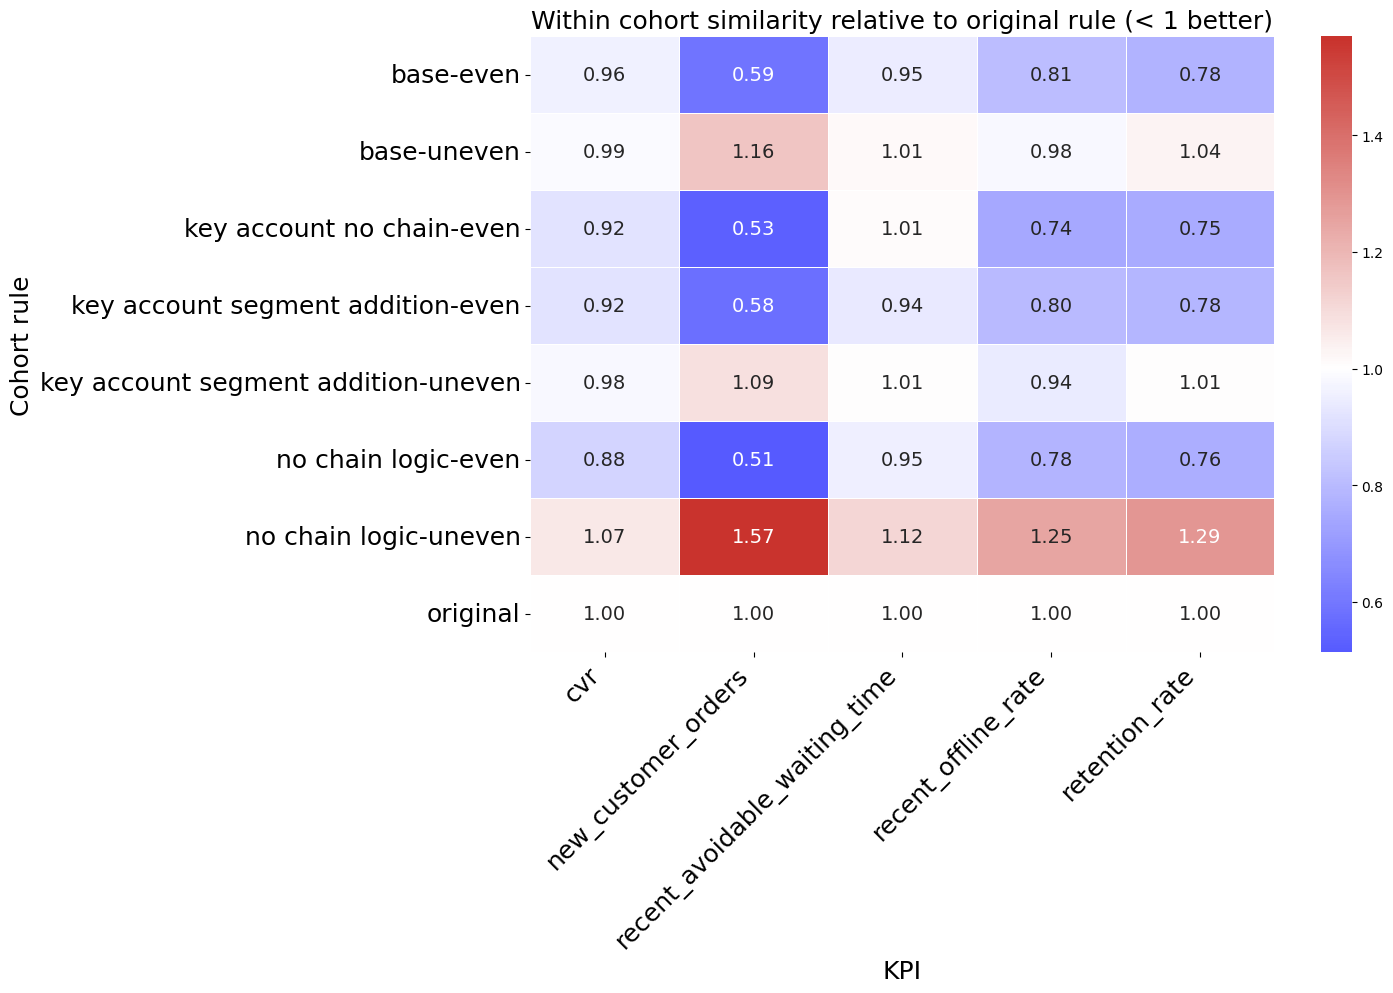

In [63]:
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_diverging',
    [DH_NAVY, 'white', DH_RED]
)

fig, ax = plt.subplots(figsize=(12, 8)) 
sns.heatmap(
    df_divided.T,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap, # Use the custom colormap
    center=1.0,
    linewidths=.5,
    annot_kws={'size': 14} # Annotation size

)
ax.set_title('Within cohort similarity relative to original rule (< 1 better)', fontsize=18)
ax.set_ylabel('Cohort rule', fontsize=18)
ax.set_xlabel('KPI', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)
new_labels = [label.get_text().replace('-recommendation (KPIs)-current', '') for label in ax.get_yticklabels()]
ax.set_yticklabels(new_labels)



plt.show()

## Step three. Recommendation quality

In [29]:
RECO_SQL_QUERY = """
SELECT 
    t.*
FROM {table_path} AS t
WHERE created_at = DATE '2025-07-28' 
AND global_entity_id NOT IN ('HS_SA', 'YS_TR')
"""

In [30]:
print("\n===== LOADING recommendations data =====")
reco_data_dfs = load_dataframes_by_type(
    specific_data_type="recommendation",
    base_sql_query_template=RECO_SQL_QUERY,
    config=path_config,
    project_id=BQ_PROJECT_ID
)


===== LOADING recommendations data =====
Starting to load 'recommendation' DataFrames...
------------------------------------------------------------
Reading: Key='base-even-recommendation-original'
  Table Path: logistics-vendor-production.pa_staging.devin_smart_recommendations_v5_step3
Downloading: 100%|██████████|
  Successfully loaded 93445 rows.
------------------------------------------------------------
Reading: Key='base-even-recommendation-current'
  Table Path: logistics-vendor-production.pa_staging.devin_smart_recommendations_v1_step3
Downloading: 100%|██████████|
  Successfully loaded 93677 rows.
------------------------------------------------------------
Reading: Key='base-uneven-recommendation-current'
  Table Path: logistics-vendor-production.pa_staging.devin_smart_recommendations_v1_step3_uneven
Downloading: 100%|██████████|
  Successfully loaded 93608 rows.
------------------------------------------------------------
Reading: Key='key account segment addition-even-re

In [31]:
combined_data = {}
for key in reco_data_dfs.keys():
    metrics_key = key.replace('recommendation', 'recommendation (KPIs)')
    tmp = pd.merge(
        metrics_data_dfs[metrics_key],
        reco_data_dfs[key],
        left_on=['entity_id', 'vendor_code'],
        right_on=['global_entity_id', 'vendor_id'],
        how='inner',
        indicator=True,
        suffixes=['_m', '']
    ).drop('cohort_id_m', axis=1)
    output_key = key.replace('-recommendation-', '-')
    combined_data[output_key] = tmp

In [32]:
growth_metric_mapping = {
    "VFD": ["recommend_vfd", "cvr", "cvr_percentile"],
    "CPC": ["recommend_cpc", "impressions", "impressions_percentile"],
    "Joker": ["recommend_joker", "new_customer_orders", "new_customer_orders_percentile"],
    "Targeted VFD": ["recommend_targeted_vfd", "retention_rate", "retention_rate_percentile"],
}

ops_metric_mapping = {
    "Online markup": "online_markup",
    "Fail rate": "vendor_fail_rate",
    "Offline rate": "offline_rate",
    "Ratings": "ratings",
    "Waiting time": "waiting_time",
    "Menu Content": "menu_content_score",
}

In [33]:
def get_gaps(df: pd.DataFrame, metric_columns: List[str], fill_na: bool = False) -> pd.DataFrame:
    """
    Calculates performance and percentile gaps for metrics within cohorts.

    Args:
        df (pd.DataFrame): The input DataFrame. Expected to contain:
                           - 'entity_id', 'cohort_id', 'vendor_code'
                           - The columns specified in `metric_columns`.
                           `metric_columns` should contain:
                           [0] `reco_col`: Binary (0/1) indicator for recommendation/treatment.
                           [1] `value_col`: The actual metric value (e.g., CVR, Impressions).
                           [2] `percentile_col`: The percentile of the `value_col`.
        metric_columns (List[str]): A list of 3 column names representing
                                    [reco_column, value_column, percentile_column].
        fill_na (bool): If True, fills NaN values in the `value_column` with 0
                        before calculating medians and gaps.

    Returns:
        pd.DataFrame: A DataFrame with 'entity_id', 'cohort_id', 'vendor_code',
                      'performance_gap', and 'pc_perf_gap'.

    Raises:
        ValueError: If `metric_columns` does not contain exactly 3 elements.
        KeyError: If any required base column ('entity_id', 'cohort_id', 'vendor_code')
                  or any column from `metric_columns` is missing from the input DataFrame.
    """
    if len(metric_columns) != 3:
        raise ValueError(
            "`metric_columns` must contain exactly 3 column names: "
            "[reco_column_name, value_column_name, percentile_column_name]"
        )

    reco_col, value_col, percentile_col = metric_columns[0], metric_columns[1], metric_columns[2]

    required_base_cols = ['global_entity_id', 'cohort_id', 'vendor_id']
    all_required_cols_for_gaps = required_base_cols + metric_columns

    # Check for all required columns
    missing_cols = [col for col in all_required_cols_for_gaps if col not in df.columns]
    if missing_cols:
        raise KeyError(f"Input DataFrame is missing required columns: {missing_cols}")

    # Select only relevant columns to avoid unnecessary memory usage
    tmp = df[required_base_cols + metric_columns].copy()

    # Handle NaN filling before median calculation
    if fill_na:
        tmp[value_col] = tmp[value_col].fillna(0)

    # Calculate cohort median for the value_column
    cohort_median = tmp.groupby('cohort_id')[value_col].median().rename("median_")
    tmp = pd.merge(tmp, cohort_median, on='cohort_id', how='left')

    # Ensure reco_col is numeric for comparison and handle potential non-binary values
    # Coerce errors to NaN then fill with 0, convert to int (assuming 0/1)
    tmp[reco_col] = pd.to_numeric(tmp[reco_col], errors='coerce').fillna(0).astype(int)

    # Calculate performance_gap and pc_perf_gap
    tmp = tmp.assign(
        performance_gap = lambda x: np.where(x[reco_col] == 1, x['median_'] - x[value_col], np.nan),
        pc_perf_gap = lambda x: np.where(x[reco_col] == 1, 0.5 - x[percentile_col], np.nan)
    )

    return tmp[required_base_cols + ['performance_gap', 'pc_perf_gap']]

In [34]:
calculated_gaps_dfs: Dict[str, Dict[str, pd.DataFrame]] = {}
unprocessed_df_metrics: List[str] = [] # To track any skipped combinations

print("--- Starting Gap Calculation ---")
print("=" * 60)

for metric_name, metric_columns_list in growth_metric_mapping.items():
    print(f"\nProcessing metric: '{metric_name}' (Columns: {metric_columns_list})")
    calculated_gaps_dfs[metric_name] = {} # Initialize nested dict for this metric

    for df_key, loaded_df in combined_data.items():
        print(f"  Applying to DataFrame: '{df_key}'")
        try:
            # Check if all columns required by get_gaps and the specific metric exist in loaded_df
            required_cols_for_this_df = ['entity_id', 'cohort_id', 'vendor_code'] + metric_columns_list
            if not all(col in loaded_df.columns for col in required_cols_for_this_df):
                missing = [col for col in required_cols_for_this_df if col not in loaded_df.columns]
                raise KeyError(f"Missing required columns: {missing}")

            # Call the get_gaps function
            gaps_df = get_gaps(loaded_df, metric_columns_list, fill_na=True) # Use fill_na=True as an example

            calculated_gaps_dfs[metric_name][df_key] = gaps_df
            print(f"    Successfully calculated gaps. Resulting DF shape: {gaps_df.shape}")

        except (KeyError, ValueError) as e:
            # Catch specific errors from get_gaps (missing columns, wrong metric_columns length)
            error_msg = f"Skipped '{df_key}' for '{metric_name}' due to data/config error: {e}"
            unprocessed_df_metrics.append(error_msg)
            print(f"    [SKIP] {error_msg}")
        except Exception as e:
            # Catch any other unexpected errors during processing
            error_msg = f"Failed to calculate gaps for '{df_key}' with metric '{metric_name}': {e}"
            unprocessed_df_metrics.append(error_msg)
            print(f"    [ERROR] {error_msg}")
        finally:
            print("-" * 60) # Separator for each DataFrame processing


print("\n--- Gap Calculation Complete ---")
if unprocessed_df_metrics:
    print("\nSome DataFrame-metric combinations could not be processed:")
    for error in unprocessed_df_metrics:
        print(f"- {error}")
print("=" * 60)

--- Starting Gap Calculation ---

Processing metric: 'VFD' (Columns: ['recommend_vfd', 'cvr', 'cvr_percentile'])
  Applying to DataFrame: 'base-even-original'
    Successfully calculated gaps. Resulting DF shape: (93375, 5)
------------------------------------------------------------
  Applying to DataFrame: 'base-even-current'
    Successfully calculated gaps. Resulting DF shape: (93608, 5)
------------------------------------------------------------
  Applying to DataFrame: 'base-uneven-current'
    Successfully calculated gaps. Resulting DF shape: (93608, 5)
------------------------------------------------------------
  Applying to DataFrame: 'key account segment addition-even-current'
    Successfully calculated gaps. Resulting DF shape: (93608, 5)
------------------------------------------------------------
  Applying to DataFrame: 'key account segment addition-uneven-current'
    Successfully calculated gaps. Resulting DF shape: (93608, 5)
----------------------------------------

In [35]:
# Convert nested dictionary to final_gaps_df (as per previous solution)
all_gaps_data = []
for metric_name, df_by_key_dict in calculated_gaps_dfs.items():
    for df_key, gaps_df in df_by_key_dict.items():
        df_with_meta = gaps_df.copy()
        df_with_meta['metric_name'] = metric_name
        df_with_meta['df_key'] = df_key
        all_gaps_data.append(df_with_meta)

final_gaps_df = pd.concat(all_gaps_data, ignore_index=True)
final_gaps_df = final_gaps_df[['df_key', 'metric_name', 'performance_gap', 'pc_perf_gap']]

In [36]:
final_gaps_df

,df_key,metric_name,performance_gap,pc_perf_gap
0,base-even-original,VFD,0.002514,0.32
1,base-even-original,VFD,NaN,NaN
2,base-even-original,VFD,0.003244,0.20
3,base-even-original,VFD,0.000823,0.50
4,base-even-original,VFD,0.002103,0.30
...,...,...,...,...
2994243,key account no chain-even-current,Targeted VFD,NaN,NaN
2994244,key account no chain-even-current,Targeted VFD,NaN,NaN
2994245,key account no chain-even-current,Targeted VFD,NaN,NaN
2994246,key account no chain-even-current,Targeted VFD,0.202717,0.45


In [37]:
from scipy.stats import ttest_ind

In [38]:
# 1. Define the baseline key
baseline_key = 'base-even-original'
results = []

# 2. Group data by 'metric_name' to perform tests within each metric
for metric, metric_df in final_gaps_df.groupby('metric_name'):

    # Get the baseline data for the current metric
    # .dropna() is important to avoid errors with missing values
    baseline_data = metric_df[metric_df['df_key'] == baseline_key]['performance_gap'].dropna()

    # If there's no baseline data for this metric, skip it
    if baseline_data.empty:
        continue

    # 3. Iterate through all other groups within the same metric
    for key, group_df in metric_df.groupby('df_key'):

        # Don't compare the baseline against itself
        if key == baseline_key:
            continue

        # Get the comparison group's data
        comparison_data = group_df['performance_gap'].dropna()
        if comparison_data.empty:
            continue

        # 4. Perform Welch's t-test (more robust)
        t_stat, p_value = ttest_ind(comparison_data, baseline_data, equal_var=False)

        # Calculate the difference in means
        mean_difference = np.mean(comparison_data) - np.mean(baseline_data)

        # Append results
        results.append({
            'metric_name': metric,
            'comparison_key': key,
            'mean_difference': mean_difference,
            't_statistic': t_stat,
            'p_value': p_value
        })

# 5. Create the final results DataFrame
ttest_results_df = pd.DataFrame(results)

# --- Display Results ---
print("--- T-Test Results (Comparison vs. Global Baseline) ---")
print(ttest_results_df)

num_comparisons = ttest_results_df.shape[0]
corrected_alpha = 0.05 / num_comparisons
print(f"To maintain a family-wise 95% confidence, the new p-value threshold is {corrected_alpha:.4f}")
print(
    "The family-wise error rate (FWER) is the probability of rejecting at least "
    "one true Hypothesis, that is, of making at least one type I error."
)

--- T-Test Results (Comparison vs. Global Baseline) ---
     metric_name                               comparison_key  \
0            CPC                            base-even-current   
1            CPC                          base-uneven-current   
2            CPC            key account no chain-even-current   
3            CPC    key account segment addition-even-current   
4            CPC  key account segment addition-uneven-current   
5            CPC                  no chain logic-even-current   
6            CPC                no chain logic-uneven-current   
7          Joker                            base-even-current   
8          Joker                          base-uneven-current   
9          Joker            key account no chain-even-current   
10         Joker    key account segment addition-even-current   
11         Joker  key account segment addition-uneven-current   
12         Joker                  no chain logic-even-current   
13         Joker                no

In [39]:
alpha = 0.05

ttest_results_df.sort_values(by='p_value', inplace=True, ascending=True)
ttest_results_df.reset_index(drop=True, inplace=True)
ttest_results_df = ttest_results_df.assign(p_rank=ttest_results_df.index + 1)
ttest_results_df = ttest_results_df.assign(bonferroni_holm_alpha=alpha / (num_comparisons + 1 - ttest_results_df.p_rank))
ttest_results_df = ttest_results_df.assign(
    significant = (ttest_results_df['p_value'] <= ttest_results_df['bonferroni_holm_alpha'])
)
ttest_results_df.loc[ttest_results_df.significant == False]

,metric_name,comparison_key,mean_difference,t_statistic,p_value,p_rank,bonferroni_holm_alpha,significant
23,CPC,key account segment addition-uneven-current,-361.313488,-1.703691,0.088444,24,0.010000,False
24,Joker,no chain logic-even-current,0.679971,0.768426,0.442237,25,0.012500,False
25,Joker,key account no chain-even-current,-0.257632,-0.307286,0.758626,26,0.016667,False
26,Targeted VFD,key account no chain-even-current,-0.000472,-0.247899,0.804214,27,0.025000,False
27,CPC,base-uneven-current,40.552332,0.189926,0.849368,28,0.050000,False


In [40]:
def plot_performance_grid(
    summary_df: pd.DataFrame,
    plot_title: str,
    y_label: str = 'Mean Performance Gap', # Re-introduced y-label for individual plots
    facet_col: str = 'metric_name',
    group_by_col: str = 'model_name',
    sub_group_by_col: str = 'df_key',
    mean_col: str = 'performance_gap_mean',
    figure_size: Tuple[float, float] = (12, 10),
    save_path: Optional[str] = None,
    show_plot: bool = True
) -> None:
    """
    Generates a 2x2 grid of grouped bar plots with independent Y-axes.

    Args:
        summary_df (pd.DataFrame): DataFrame with aggregated data.
        plot_title (str): The main title for the entire figure.
        y_label (str): The label for the y-axis of each subplot.
        facet_col (str): Column whose unique values define each subplot. Max 4.
        group_by_col (str): Column for the x-axis of each subplot.
        sub_group_by_col (str): Column for sub-grouping (hue) within each subplot.
        mean_col (str): Column with mean values for bar heights.
        figure_size (Tuple[float, float]): Size of the entire figure.
        save_path (Optional[str]): Path to save the figure.
        show_plot (bool): If True, displays the plot.
    """
    # --- 1. Validation and Setup ---
    required_cols = [facet_col, group_by_col, sub_group_by_col, mean_col]
    if not all(col in summary_df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in summary_df.columns]
        raise ValueError(f"Input summary_df is missing required columns: {missing}")

    metrics = summary_df[facet_col].unique()
    if len(metrics) > 4:
        raise ValueError(f"This function supports up to 4 metrics, but {len(metrics)} were found.")

    # --- 2. Create Consistent Color Palette ---
    hue_order = sorted(summary_df[sub_group_by_col].unique())
    palette = dict(zip(hue_order, sns.color_palette('viridis', n_colors=len(hue_order))))

    # --- 3. Create 2x2 Subplot Grid with Independent Y-Axes ---
    # CHANGED: sharey is now False to allow independent y-axis ranges.
    fig, axes = plt.subplots(2, 2, figsize=figure_size, sharey=False)
    axes_flat = axes.flatten()

    # --- 4. Iterate and Plot on Each Axis ---
    for i, metric in enumerate(metrics):
        ax = axes_flat[i]
        metric_df = summary_df[summary_df[facet_col] == metric]

        sns.barplot(
            data=metric_df,
            x=group_by_col,
            y=mean_col,
            hue=sub_group_by_col,
            hue_order=hue_order,
            palette=palette,
            ax=ax,
            errorbar=('ci', 95),
            capsize=0.1,
            err_kws={'color': 'gray','linewidth': 1.5},
        )

        ax.set_title(metric.replace('_', ' ').title(), fontsize=16)
        ax.axhline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.7)
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45, labelsize=16)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.set_xticklabels([])
        ax.set_ylabel(y_label)

        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # --- 5. Clean Up and Finalize Figure ---
    for i in range(len(metrics), len(axes_flat)):
        axes_flat[i].set_visible(False)

    # CHANGED: Removed fig.supylabel and added a figure-level x-label.
    fig.supxlabel(group_by_col.replace('_', ' ').title(), y=0.02)

    legend_patches = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]
    fig.legend(
        handles=legend_patches,
        title=sub_group_by_col.replace('_', ' ').title(),
        bbox_to_anchor=(1.01, 0.95),
        loc='upper left',
        fontsize=16
    )

    fig.suptitle(plot_title, fontsize=16, y=0.98)
    plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])

    # --- 6. Saving and Showing Logic ---
    if save_path:
        # ... (saving logic remains the same)
        output_dir = os.path.dirname(save_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)

--- Plotting Mean Performance Gap (Grouped Bar Plot) ---
Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/mean_performance_gap_grouped_barplot.png


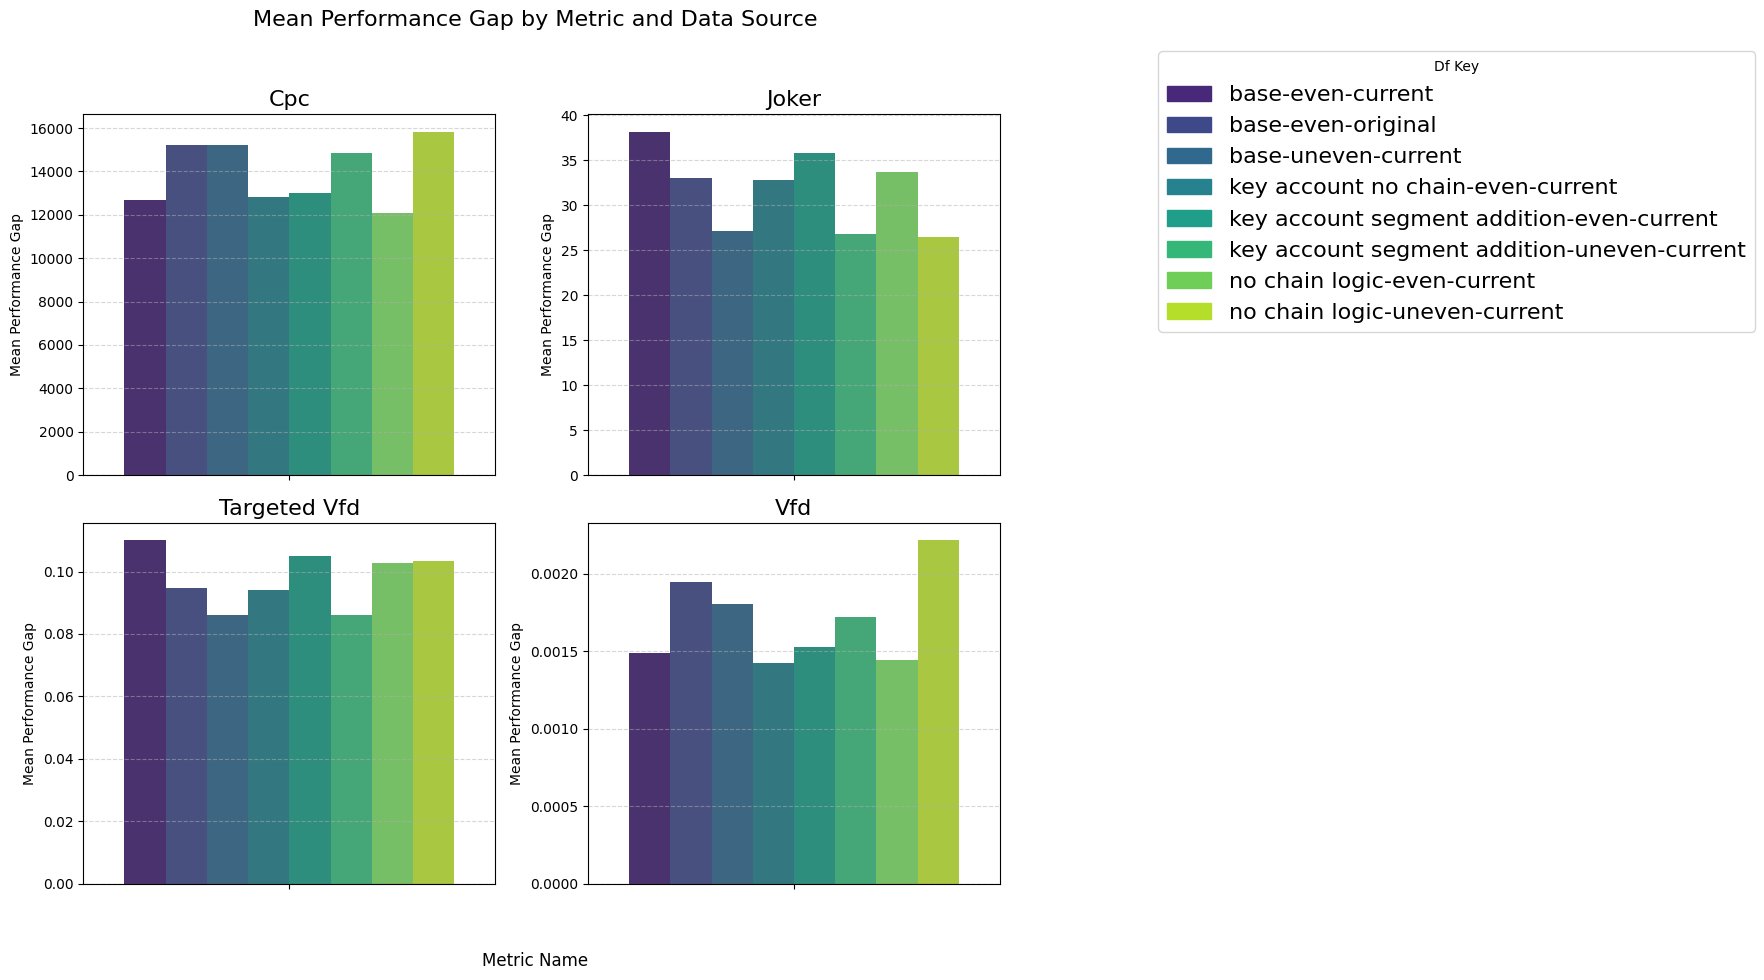

In [41]:
# Call 1: Plotting Performance Gap with 95% CI
print("--- Plotting Mean Performance Gap (Grouped Bar Plot) ---")
plot_performance_grid(
    summary_df=final_gaps_df.groupby(['df_key', 'metric_name']).performance_gap.mean().reset_index(),
    plot_title='Mean Performance Gap by Metric and Data Source',
    facet_col='metric_name',
    group_by_col='metric_name', # X-axis
    sub_group_by_col='df_key',   # Hue
    mean_col='performance_gap',
    save_path=BASE_PLOT_PATH / 'mean_performance_gap_grouped_barplot.png',
    show_plot=True
)

In [42]:
df_mean_gaps = final_gaps_df.groupby(['df_key', 'metric_name']).performance_gap.mean().reset_index()
df_gap_pivoted = df_mean_gaps.pivot_table(index='metric_name', columns='df_key', values='performance_gap')
df_gap_pivoted = df_gap_pivoted.div(df_gap_pivoted['base-even-original'], axis=0)
df_gap_pivoted

df_key,base-even-current,base-even-original,base-uneven-current,key account no chain-even-current,key account segment addition-even-current,key account segment addition-uneven-current,no chain logic-even-current,no chain logic-uneven-current
metric_name,,,,,,,,
CPC,0.832860,1.0,1.002668,0.842800,0.855772,0.976229,0.796193,1.042110
Joker,1.156284,1.0,0.821426,0.992200,1.085200,0.812294,1.020586,0.800448
Targeted VFD,1.162723,1.0,0.908533,0.995018,1.108106,0.909123,1.084187,1.091377
VFD,0.763622,1.0,0.926044,0.732114,0.783786,0.884013,0.739446,1.138033


In [43]:
df_pivoted = df_outlier.pivot_table(index='value', columns='df_name', values='ms_w_manual')
df_divided = df_pivoted.div(df_pivoted['original'], axis=0)
df_divided

NameError: name 'df_outlier' is not defined

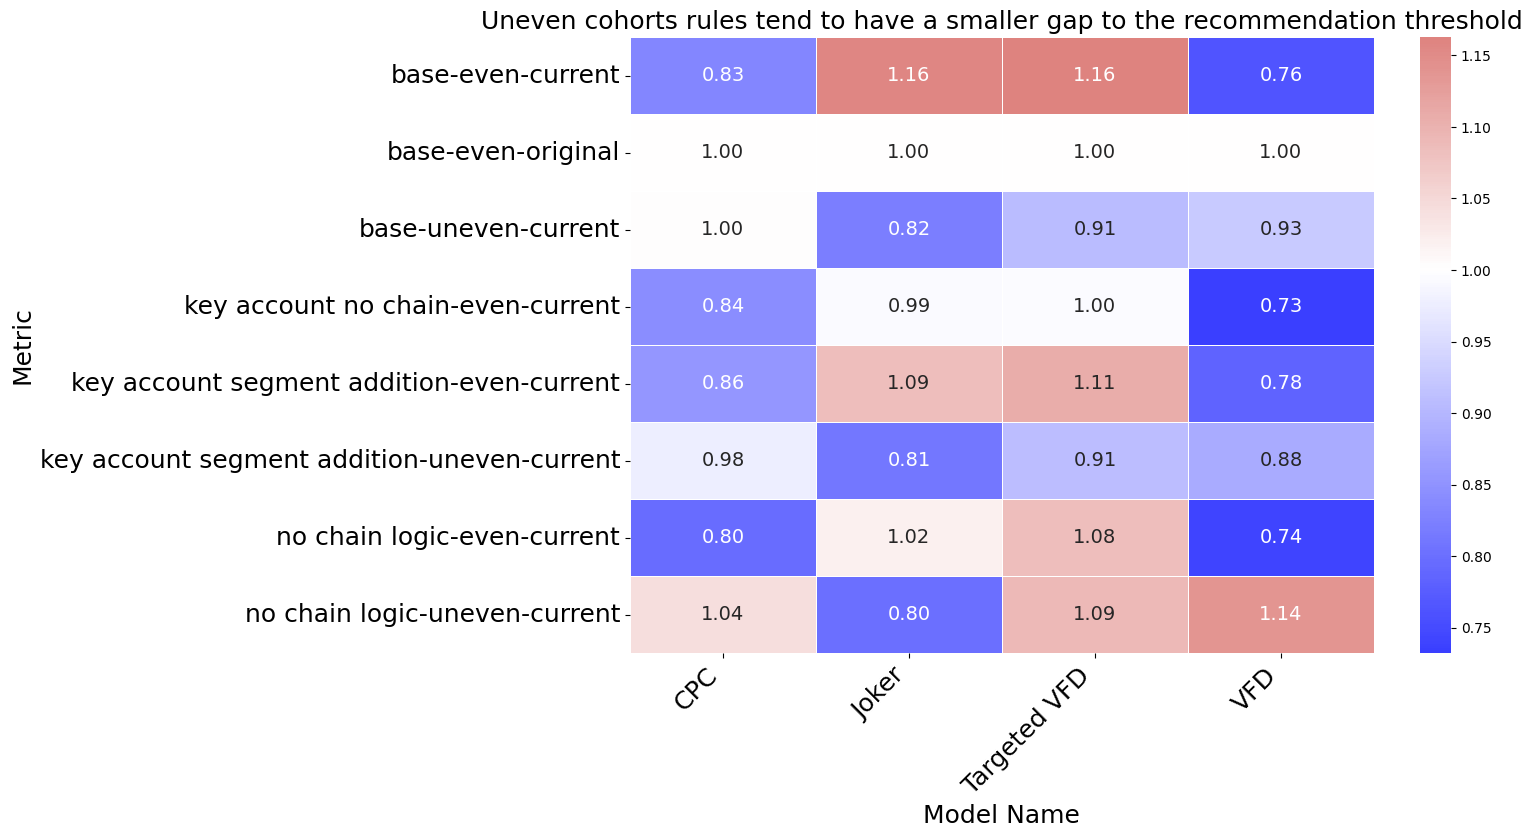

In [44]:
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_diverging',
    [DH_NAVY, 'white', DH_RED]
)

# 3. Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_gap_pivoted.T,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap, # Use the custom colormap
    center=1.0,
    linewidths=.5,
    annot_kws={'size': 14} # Annotation size
)
plt.title('Uneven cohorts rules tend to have a smaller gap to the recommendation threshold', fontsize=18)
plt.ylabel('Metric', fontsize=18)
plt.xlabel('Model Name', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=18)

plt.show()

In [45]:
reco_data_dfs.keys()

dict_keys(['base-even-recommendation-original', 'base-even-recommendation-current', 'base-uneven-recommendation-current', 'key account segment addition-even-recommendation-current', 'key account segment addition-uneven-recommendation-current', 'no chain logic-even-recommendation-current', 'no chain logic-uneven-recommendation-current', 'key account no chain-even-recommendation-current'])

In [52]:
all_columns = reco_data_dfs['key account segment addition-even-recommendation-current'].columns
reco_cols = [x for x in all_columns if 'recommend_' in x]

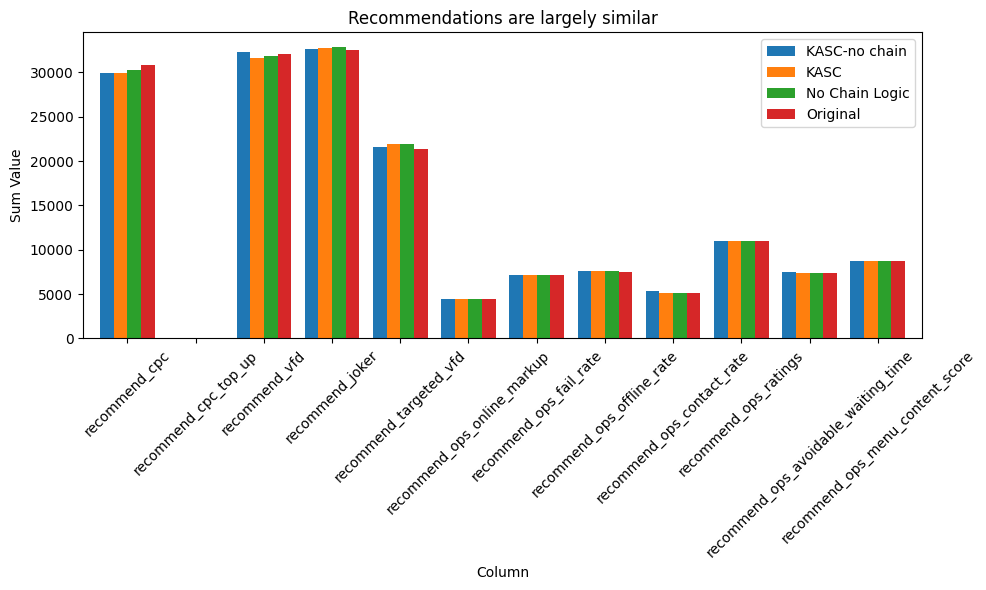

In [55]:

# Calculate the sum for each DataFrame and relevant columns
sum_reco_no_chain = reco_data_dfs['key account no chain-even-recommendation-current'][reco_cols].sum()
sum_reco = reco_data_dfs['key account segment addition-even-recommendation-current'][reco_cols].sum()
sum_no_chain = reco_data_dfs['no chain logic-even-recommendation-current'][reco_cols].sum()
sum_base = reco_data_dfs['base-even-recommendation-original'][reco_cols].sum()

# Combine these sums into a single DataFrame for plotting
df_plot = pd.DataFrame({
    'KASC-no chain': sum_reco_no_chain,
    'KASC': sum_reco,
    'No Chain Logic': sum_no_chain,
    'Original': sum_base
})

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
df_plot.plot(kind='bar', ax=ax, width=0.8)

ax.set_title('Recommendations are largely similar')
ax.set_xlabel('Column')
ax.set_ylabel('Sum Value')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
